In [1]:
import jax.numpy as np
import numpy.random as npr
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap, partial
from jax.lax import scan
from jax.scipy.special import logsumexp
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
@jit
def f(x, u):
    xnew = x + 2*np.tanh(u)
    return xnew, x
@jit
def p(x):
#     return 1.0
    x1 = x-np.array([0.7, 0.5])
    x2 = x+np.array([-0.7, 0.5])
    return np.exp(-0.5*np.sum((x1/0.2)**2)) \
            + np.exp(-0.5*np.sum((x2/0.2)**2))

@jit
def dist(x, s):
    dx = x-s
    return -0.5 * np.sum((dx/0.1)**2)

logexp_vmap = lambda _x, _s: logsumexp(vmap(dist, in_axes=(0, None))(_x, _s))

def loss(u, x0, si, xT=False):
    xf, tr = scan(f, x0, u)
    ell = -np.mean(vmap(partial(logexp_vmap, tr))(si) * vmap(p)(si)) + np.mean(u**2)#+ np.mean(vmap(p)(si) * np.log(vmap(p)(si)))
    if xT:
        return ell, tr 
    return ell

dl = jit(grad(loss))
dlsi = jit(grad(loss, 2))

In [3]:
x0 = np.array([-0.5,0.0])
# u = np.stack([np.array([0.001, -0.001])*np.sin(0.1*t) for t in range(400)])
u = np.zeros((100,2))

# si = npr.uniform(-1,1, size=(10,2))
si = npr.uniform(-1,1, size=(40,2))

x_test, y_test = np.meshgrid(*[np.linspace(-1,1)]*2)
map_pts = np.stack([x_test.ravel(), y_test.ravel()]).T
loss(u, x0, si)

/home/burn/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(7.8009543, dtype=float32)

-0.14679931 [-0.5  0. ] [-0.5  0. ] [0.1574794  0.05478967]


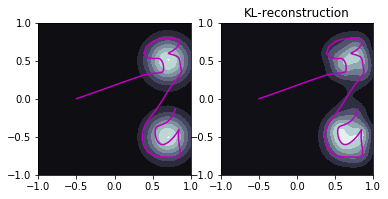

<Figure size 432x288 with 0 Axes>

In [17]:
for k in range(1000):
#     xf, tr = scan(f, x0, u)

    si = npr.uniform(-1,1, size=(40,2))

#     weights = vmap(p)(si)
#     for _ in range(10):
#         weights /= np.sum(weights)
    
#     if 1.0/np.sum(np.square(weights)) < len(weights):
#         print(np.sum(weights))
#         si = simple_resample(si, weights)
#         si += npr.normal(0., 0.01, size=si.shape)

    u -= 0.001 * dl(u, x0, si)
    if k % 100 == 0:
        clear_output(wait=True)
        
        fig, ax = plt.subplots(1, 2)
        _el, pred_tr = loss(u, x0, si, xT=True)
        print(_el, pred_tr[0], x0, u[0])
        
        pdf = vmap(p)(map_pts).reshape(x_test.shape)
        pdf /= np.sum(pdf)
        
        recon = np.exp(vmap(partial(logexp_vmap, pred_tr))(map_pts))
#         pdf = vmap(p)(x_test)
        ax[0].contourf(x_test, y_test, pdf, cmap='bone')
#         plt.plot(x0[0], x0[1], 'm')
#         plt.plot(pred_tr[0,0], pred_tr[0,1], 'mo')
        ax[1].contourf(x_test, y_test, recon.reshape(x_test.shape), cmap='bone')

        ax[1].plot(pred_tr[:,0], pred_tr[:,1], 'm')
        ax[0].plot(pred_tr[:,0], pred_tr[:,1], 'm')
        ax[1].set_title('KL-reconstruction')
        ax[0].axis('equal')
        ax[0].axis('square')
        ax[1].axis('equal')
        ax[1].axis('square')
#         plt.xlim(-1,1)
#         plt.ylim(-1,1)
#         plt.scatter(si[:,0], si[:,1], c='r')
        plt.pause(0.01)
#     x0 = f(x0, u[1])[0]
plt.savefig('kl-ergodic-coverage.pdf') 

# plt.show()

In [23]:
from matplotlib import rc
rc('text', usetex=True)

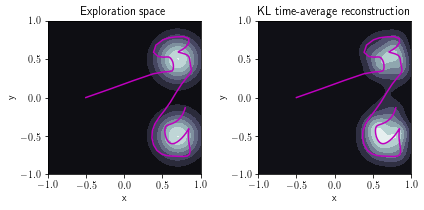

In [29]:
    
fig, ax = plt.subplots(1, 2)
recon = np.exp(vmap(partial(logexp_vmap, pred_tr))(map_pts))
ax[0].contourf(x_test, y_test, pdf, cmap='bone')
ax[1].contourf(x_test, y_test, recon.reshape(x_test.shape), cmap='bone')

ax[1].plot(pred_tr[:,0], pred_tr[:,1], 'm')
ax[0].plot(pred_tr[:,0], pred_tr[:,1], 'm')
ax[0].set_title('Exploration space')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('KL time-average reconstruction')
ax[0].axis('equal')
ax[0].axis('square')
ax[1].axis('equal')
ax[1].axis('square')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
plt.tight_layout()

plt.savefig('kl-ergodic-coverage.pdf') 

In [47]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = onp.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = onp.searchsorted(cumulative_sum, npr.random(N))
    
    indexes = npr.choice(len(particles), size=(len(particles),), p=weights)
    # weights.fill(1.0 / N)
    return particles[indexes]

In [188]:
si = simple_resample(si, weights)
si += npr.normal(0., 0.1, size=si.shape)

weights = vmap(p)(si)
weights /= np.sum(weights)

IndexError: index 15 is out of bounds for axis 0 with size 10

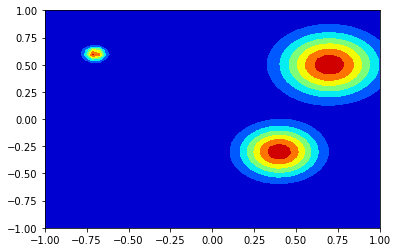

In [255]:

plt.contourf(x_test, y_test, pdf, cmap='jet')
plt.scatter(si[idxs,0], si[idxs,1])

In [2]:
import torch
from torch.autograd.functional import jacobian

In [23]:
def f(x, y):
    return x.exp() + torch.pow(y, 2)

inputs = (torch.rand(3,2), torch.rand(3,2))

jacobian(f, inputs)[0].shape

torch.Size([3, 2, 3, 2])